In [ ]:
import os
import csv
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter

import pandas as pd
from PIL import Image

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.AutoAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])
])

In [4]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])
])

In [5]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4850, 0.4560, 0.4060], std=[0.2290, 0.2240, 0.2250])
])

In [ ]:
class Pokemon8n9Dataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.data_frame.iloc[idx, 0]
        image = Image.open(img_name)

        if image.mode != 'RGB':
            image = image.convert('RGB')
        
        label = int(self.data_frame.iloc[idx, 1])

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
train_paths = 'D:/課程資料/深度學習應用開發實務/FinalProject/pokemon8&9_train.csv'
val_paths = 'D:/課程資料/深度學習應用開發實務/FinalProject/pokemon8&9_val.csv'
test_paths = 'D:/課程資料/深度學習應用開發實務/FinalProject/pokemon8&9_test.csv'
train_dataset = Pokemon8n9Dataset(csv_file=train_paths, transform=train_transform)
val_dataset = Pokemon8n9Dataset(csv_file=val_paths, transform=val_transform)
test_dataset = Pokemon8n9Dataset(csv_file=test_paths, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [ ]:
df = pd.read_csv(train_paths)
data_list = list()
last_label = -1
for i in range(len(df)):
    if int(df.iloc[i,1]) != last_label:
        data_list.append(1)
        last_label = int(df.iloc[i,1])
    data_list[len(data_list)-1] += 1
w = [len(df) / (len(data_list) * num_samples) for num_samples in data_list]
w_tensor = torch.tensor(w).to(device)

In [ ]:
model = models.vit_b_32(weights=models.ViT_B_32_Weights)
model.heads[0] = nn.Linear(model.heads[0].in_features, 28)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=0.001, lr=0.00001)

model.to(device)

currentTime = datetime.now().strftime("%Y%m%d%H%M%S")
writer = SummaryWriter(f'logs/{currentTime}')

c:\Users\mingyiao\anaconda3\envs\dlapp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
num_epochs = 80
best_accuracy = 0.0
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

        val_loss = running_val_loss / len(val_loader.dataset)
        val_accuracy = correct_val / total_val

        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        if val_accuracy > best_accuracy:
            # Save model weights
            torch.save(model.state_dict(), f'logs/{currentTime}/best_model_bit_b_32.pth')
            best_accuracy = val_accuracy

        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
writer.close()

c:\Users\mingyiao\anaconda3\envs\dlapp\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/80, Training Loss: 2.6448, Training Accuracy: 0.3643
Validation Loss: 1.6572, Validation Accuracy: 0.7249
Epoch 2/80, Training Loss: 1.2031, Training Accuracy: 0.7876
Validation Loss: 0.7598, Validation Accuracy: 0.8773
Epoch 3/80, Training Loss: 0.6562, Training Accuracy: 0.8959
Validation Loss: 0.4943, Validation Accuracy: 0.9108
Epoch 4/80, Training Loss: 0.4468, Training Accuracy: 0.9280
Validation Loss: 0.3826, Validation Accuracy: 0.9219
Epoch 5/80, Training Loss: 0.3320, Training Accuracy: 0.9452
Validation Loss: 0.3552, Validation Accuracy: 0.9294
Epoch 6/80, Training Loss: 0.2772, Training Accuracy: 0.9554
Validation Loss: 0.2894, Validation Accuracy: 0.9480
Epoch 7/80, Training Loss: 0.2208, Training Accuracy: 0.9628
Validation Loss: 0.2960, Validation Accuracy: 0.9405
Epoch 8/80, Training Loss: 0.1719, Training Accuracy: 0.9721
Validation Loss: 0.2562, Validation Accuracy: 0.9331
Epoch 9/80, Training Loss: 0.1638, Training Accuracy: 0.9703
Validation Loss: 0.2407, Va

In [12]:
classes = {
    0: 'Anokusa', 1: 'Doo', 2: 'Gakegini', 3: 'Guruton',
    4: 'Harabari', 5: 'Hibani', 6: 'Hogeta', 7: 'Hoshigarisu',
    8: 'Ikirinko', 9: 'Irukaman', 10: 'Kaiden', 11: 'Kamukame',
    12: 'Kanuchan', 13: 'Kuwassu', 14: 'Mahoippu', 15: 'Miburimu',
    16: 'Mimizuzu', 17: 'Minibu', 18: 'Morupeko', 19: 'Namiiruka',
    20: 'Nyaoha', 21: 'Pamo', 22: 'Sarunori', 23: 'Sobureizu',
    24: 'Terapagosu', 25: 'Umidiguda', 26: 'Wanpachi', 27: 'Yabacha'
}

In [ ]:
import matplotlib.pyplot as plt

model.load_state_dict(torch.load('D:/課程資料/深度學習應用開發實務/FinalProject/best_model_bit_b_32.pth'))

model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0
correct_samples = {i: None for i in range(len(classes))}
wrong_samples = list()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        for i in range(len(inputs)):
            label = labels[i].item()
            prediction = predicted[i].item()
            if label == prediction and correct_samples[label] is None:
                correct_samples[label] = (inputs[i].cpu(), label)
            elif label != prediction:
                wrong_samples.append([inputs[i].cpu(), label, prediction])

test_loss = running_test_loss / len(test_loader.dataset)
test_accuracy = correct_test / total_test

print(f'Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}')

Testing Loss: 0.1741, Testing Accuracy: 0.9740


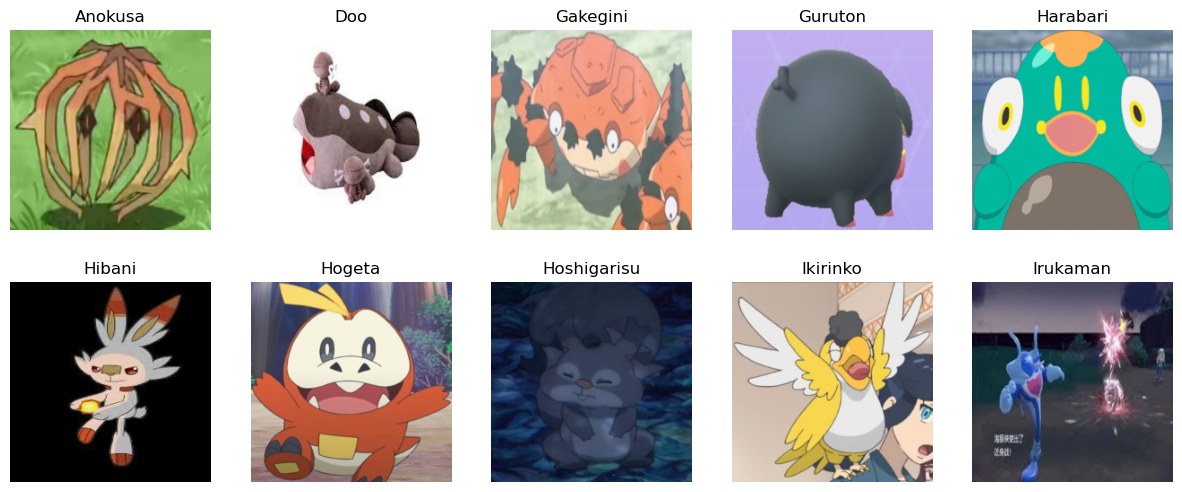

In [ ]:
# show correct inference
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
cnt = 0
for i, (img, label) in correct_samples.items():
    if img is not None:
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)
        axs[cnt].imshow(img)
        axs[cnt].set_title(classes[label])
        axs[cnt].axis('off')
        cnt += 1
    if cnt == 10:
        break
plt.show()

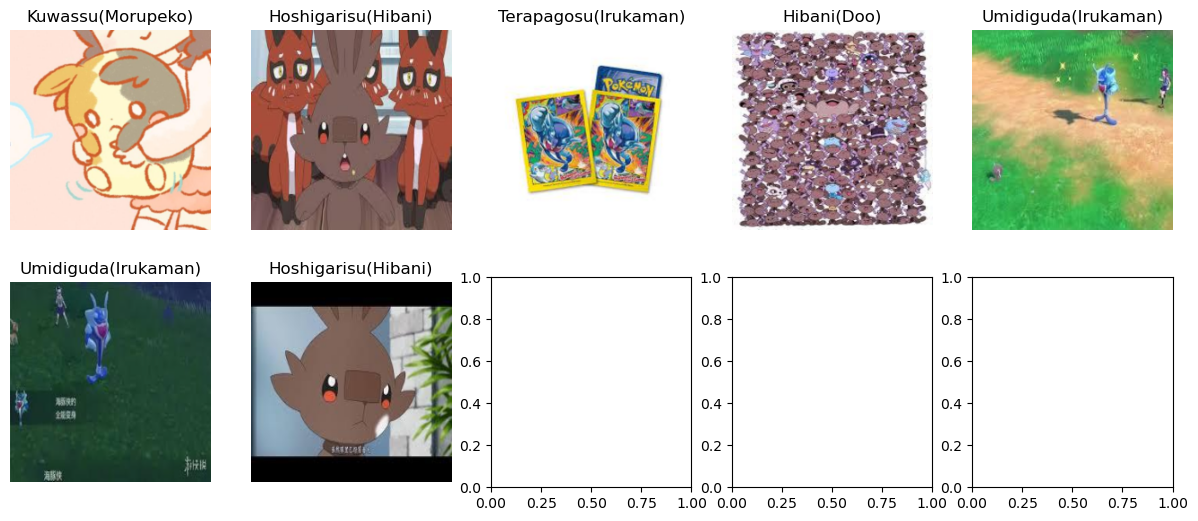

In [ ]:
# show false inference
import random

random.shuffle(wrong_samples)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
axs = axs.flatten()
cnt = 0
for [img, label, pred] in wrong_samples:
    if img is not None:
        img = img.permute(1, 2, 0)
        img = img * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        img = img.clamp(0, 1)
        axs[cnt].imshow(img)
        axs[cnt].set_title(f'{classes[pred]}({classes[label]})')
        axs[cnt].axis('off')
        cnt += 1
    if cnt == 10:
        break
plt.show()